# Data Gathering

In [1]:
#import libraries
import tweepy
import pandas as pd
import numpy as np
import requests
import re
import os
import seaborn as sns
import csv
import warnings
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline


# Data Gathering 

In [2]:
    #load files
    #twitter archive
    archive_df=pd.read_csv('twitter-archive-enhanced.csv')

    #load image predictions using url under /dogs
    foldername = 'dogs'
    if not os.path.exists(foldername):
        os.makedirs(foldername)

    url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
    response = requests.get(url, allow_redirects=True)    
    with open (os.path.join(foldername,url.split('/')[-1]),mode='wb') as file:
        file.write(response.content)

    #Create and read image_pred df    
    image_prediction_df = pd.read_csv('dogs/image-predictions.tsv', delimiter="\t")

In [3]:
#testing image pred file
os.listdir(foldername)

['image-predictions.tsv']

In [4]:
#load Twitter API data from file
filename = "tweet-json.txt"
df_list = []
with open(filename) as file:
    for line in file:
        tweet = json.loads(line)
        tweet_id = tweet["id_str"]
        retweet_count = tweet["retweet_count"]
        favorite_count = tweet["favorite_count"]
        # collect needed fields
        df_list.append({'tweet_id' : tweet_id,'retweet_count' : retweet_count,'favorite_count' : favorite_count})

#convert to DF        
api_df= pd.DataFrame ( df_list, columns = ['tweet_id', 'retweet_count' , 'favorite_count'])
api_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [5]:
#Merge both archive and API DFs
archive_df= pd.merge(archive_df,api_df, left_index=True, right_index=True, how='left')


# Data Assessing

## Visual and Programatic Assessment feedback

for visual, files were opened using excel:

    In the twitter-archive-enhanced:
        
        #Twitter Archive df(after adding with retweet and fav count from API) :
    1.	Extra column after mergring with tweet id
    2.	Exclude any retweet
    3.	Exclude any tweets with no image (2297 have images)
    4.	Issue with the last 4 fields "doggo/floofer/pupper/puppo", should be grouped as one for classification
    5.	Some retweet columns that are useless after removing retweets
    6.	Change type of tweet_id(string) timestamp(time)
    7.	Such was used as name due to wrongfully string extraction, will be corrected manully
    8.	Correct rating by exporting it from text
    9.	rename expanded_urls to Image_url
    10.	drop lines with 'a' or 'an' as name


        
        #image_prediction_df
    a.	Rename the columns of image prediction to more descriptive names
    b.	group image prediction outcomes into 3 columns instead of 9
    c.	remove all non-dog breeds (false)


## Programatic Assessment steps

In [6]:
# check info
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 20 columns):
tweet_id_x                    2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
tweet_id_y                    23

In [7]:
#check header and first 5 rows
archive_df.head()

,tweet_id_x,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,tweet_id_y,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,892420643555336193,8853.0,39467.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,892177421306343426,6514.0,33819.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,891815181378084864,4328.0,25461.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,891689557279858688,8964.0,42908.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,891327558926688256,9774.0,41048.0


In [8]:
#check random sample of 5
archive_df.sample(5)

,tweet_id_x,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,tweet_id_y,retweet_count,favorite_count
1699,680970795137544192,NaN,NaN,2015-12-27 04:37:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I thought I made this very clear. We only rate...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680970795...,9,10,None,None,None,None,None,680940246314430465,1225.0,3544.0
614,796759840936919040,NaN,NaN,2016-11-10 17:02:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Romeo. He was just told that it's...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/796759840...,11,10,Romeo,None,None,None,None,796563435802726400,8536.0,0.0
1951,673686845050527744,NaN,NaN,2015-12-07 02:13:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is George. He's upset that the 4th of Jul...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673686845...,11,10,George,None,None,None,None,673662677122719744,397.0,1339.0
650,792883833364439040,NaN,NaN,2016-10-31 00:20:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bailey. She's rather h*ckin hype for H...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792883833...,12,10,Bailey,None,None,None,None,792773781206999040,1963.0,8209.0
593,798925684722855936,NaN,NaN,2016-11-16 16:28:21 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Shadow. He's a firm believer that they...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/798925684...,11,10,Shadow,None,None,None,None,798705661114773508,7724.0,0.0


In [9]:
# value count of classes
print(archive_df['doggo'].value_counts(),

archive_df['floofer'].value_counts(),

archive_df['pupper'].value_counts(),

archive_df['puppo'].value_counts())

None     2259
doggo      97
Name: doggo, dtype: int64 None       2346
floofer      10
Name: floofer, dtype: int64 None      2099
pupper     257
Name: pupper, dtype: int64 None     2326
puppo      30
Name: puppo, dtype: int64


In [10]:
#check for duplicate tweets
archive_df[archive_df.tweet_id_x.duplicated()]

,tweet_id_x,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,tweet_id_y,retweet_count,favorite_count


In [11]:
image_prediction_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [12]:
image_prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [13]:
image_prediction_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [14]:
#True vs False 
print (image_prediction_df['p1_dog'].value_counts().to_dict())
print (image_prediction_df['p2_dog'].value_counts().to_dict())
print (image_prediction_df['p3_dog'].value_counts().to_dict())


{True: 1532, False: 543}
{True: 1553, False: 522}
{True: 1499, False: 576}


In [15]:
#most common types
print (image_prediction_df['p1'].value_counts().idxmax())
print (image_prediction_df['p2'].value_counts().idxmax())
print (image_prediction_df['p3'].value_counts().idxmax())


golden_retriever
Labrador_retriever
Labrador_retriever


In [16]:
#statistic analysis
print (image_prediction_df['p1_conf'].describe())
print (image_prediction_df['p2_conf'].describe())
print (image_prediction_df['p3_conf'].describe())


count    2075.000000
mean        0.594548
std         0.271174
min         0.044333
25%         0.364412
50%         0.588230
75%         0.843855
max         1.000000
Name: p1_conf, dtype: float64
count    2.075000e+03
mean     1.345886e-01
std      1.006657e-01
min      1.011300e-08
25%      5.388625e-02
50%      1.181810e-01
75%      1.955655e-01
max      4.880140e-01
Name: p2_conf, dtype: float64
count    2.075000e+03
mean     6.032417e-02
std      5.090593e-02
min      1.740170e-10
25%      1.622240e-02
50%      4.944380e-02
75%      9.180755e-02
max      2.734190e-01
Name: p3_conf, dtype: float64


In [17]:
archive_df.describe()

,tweet_id_x,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,retweet_count,favorite_count
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000,2354.000000,2354.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433,3164.797366,8080.968564
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237,5284.770364,11814.771334
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000,624.500000,1415.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000,1473.500000,3603.500000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000,3652.000000,10122.250000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000,79515.000000,132810.000000


# Clean 

In [96]:
# create copies of DFs and renaming to '_c' to identify them
archive_c = archive_df.copy()
api_c = api_df.copy()
image_prediction_c = image_prediction_df.copy()

#### Define
    Extra column after mergring with tweet id

In [97]:
###Code
del archive_c['tweet_id_y']


In [20]:
###test
archive_c.head(1)

,tweet_id_x,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,8853.0,39467.0


###Define
##Tidiness
    *Exclude any retweets 

In [98]:
#code
archive_c = archive_c[pd.isnull(archive_c['in_reply_to_status_id'])]
archive_c = archive_c[pd.isnull(archive_c['retweeted_status_id'])]

In [22]:
#test
archive_c.head()

,tweet_id_x,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,8853.0,39467.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,6514.0,33819.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,4328.0,25461.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,8964.0,42908.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,9774.0,41048.0


Define:

*Exclude any tweets with no image (2297 have images)

In [99]:
#Code
archive_c = archive_c.dropna(subset=['expanded_urls'])

In [24]:
#Test for blanks in expanded_urls
(archive_c['expanded_urls'] == '').sum()


0

Define:
        * issue with the last 4 fields "doggo/floofer/pupper/puppo", should be grouped as one for classification

In [100]:
#remove 'none'
archive_c[['doggo', 'floofer','pupper','puppo']]= archive_c[['doggo', 'floofer','pupper','puppo']].replace('None', "")


In [101]:
#create a new column 'class' and combine result of 4 columns in it
archive_c['Class'] = archive_c[archive_c.columns[14:17]].apply(lambda x: ''.join(x.dropna().astype(str)),
    axis=1)


In [27]:
#test by checking sample
archive_c.sample(50)

,tweet_id_x,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,Class
400,824775126675836928,NaN,NaN,2017-01-27 00:24:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Scooter. His lack of opposable thumbs ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/824775126...,12,10,Scooter,,,,,1993.0,11113.0,
1017,746872823977771008,NaN,NaN,2016-06-26 01:08:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a carrot. We only rate dogs. Please on...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746872823...,11,10,a,,,,,1806.0,5345.0,
1793,677331501395156992,NaN,NaN,2015-12-17 03:36:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Humphrey. He's a Northern Polyp Viagra. O...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677331501...,9,10,Humphrey,,,,,611.0,1799.0,
1393,700029284593901568,NaN,NaN,2016-02-17 18:49:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Coops. His ship is taking on water. So...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/700029284...,10,10,Coops,,,,,1088.0,3345.0,
1848,675798442703122432,NaN,NaN,2015-12-12 22:04:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bernie. He just touched a boob for the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675798442...,10,10,Bernie,,,,,388.0,1257.0,
1489,692905862751522816,NaN,NaN,2016-01-29 03:03:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Wally. He's being abducted by aliens. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/692905862...,10,10,Wally,,,pupper,,910.0,2511.0,pupper
1196,717047459982213120,NaN,NaN,2016-04-04 17:53:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Flávio (pronounced Baxter). He's a Ben...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/717047459...,12,10,Flávio,,,,,1317.0,4627.0,
970,750117059602808832,NaN,NaN,2016-07-05 00:00:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Calvin. He just loves America so much....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750117059...,10,10,Calvin,,,,,613.0,2383.0,
293,837820167694528512,NaN,NaN,2017-03-04 00:21:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Here's a pupper before and after being asked ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/837820167...,12,10,None,,,pupper,,495.0,4204.0,pupper
966,750383411068534784,NaN,NaN,2016-07-05 17:38:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoe. She was trying to stealthily take...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750383411...,9,10,Zoe,,,pupper,,1095.0,3409.0,pupper


In [102]:
#drop the old fields
archive_c.drop(columns=['doggo' , 'floofer', 'pupper' , 'puppo'], inplace=True)

In [103]:
#replace "" with nan
archive_c['Class'].replace('', np.nan)

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10          NaN
11          NaN
12        puppo
13          NaN
14        puppo
15          NaN
16          NaN
17          NaN
18          NaN
20          NaN
21          NaN
22          NaN
23          NaN
24          NaN
25          NaN
26          NaN
27          NaN
28          NaN
29       pupper
31          NaN
33          NaN
34          NaN
35          NaN
37          NaN
38          NaN
39          NaN
40          NaN
41          NaN
42          NaN
43          NaN
44          NaN
45          NaN
46      floofer
47          NaN
48          NaN
49       pupper
50          NaN
51          NaN
52          NaN
53          NaN
54          NaN
56       pupper
57          NaN
58          NaN
59          NaN
60          NaN
61          NaN
62          NaN
63          NaN
65          NaN
66          NaN
67          NaN
69      

In [30]:
#test for header
archive_c.head(1)

,tweet_id_x,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,Class
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,8853.0,39467.0,


In [31]:
#test for Class values
archive_c['Class'].describe()


count     2094
unique       4
top           
freq      1831
Name: Class, dtype: object

In [32]:
#define
    #3*Some retweet columns that are useless after removing retweets

In [33]:
archive_c['Class'].describe()

count     2094
unique       4
top           
freq      1831
Name: Class, dtype: object

In [34]:
#code
archive_c.drop(columns=['in_reply_to_status_id' , 'in_reply_to_user_id', 'retweeted_status_id' , 'retweeted_status_user_id' , 'retweeted_status_timestamp'], inplace=True)

In [35]:
#test
archive_c.head()

,tweet_id_x,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,Class
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,8853.0,39467.0,
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,6514.0,33819.0,
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,4328.0,25461.0,
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,8964.0,42908.0,
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,9774.0,41048.0,


In [36]:
#define
  #  4*Change type of tweet_id(string) timestamp(time)

In [104]:
#Code
archive_c['tweet_id_x'] = archive_c.tweet_id_x.astype(str)
archive_c['timestamp'] = pd.to_datetime(archive_c['timestamp'])


In [38]:
#test
archive_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id_x            2094 non-null object
timestamp             2094 non-null datetime64[ns]
source                2094 non-null object
text                  2094 non-null object
expanded_urls         2094 non-null object
rating_numerator      2094 non-null int64
rating_denominator    2094 non-null int64
name                  2094 non-null object
retweet_count         2092 non-null float64
favorite_count        2092 non-null float64
Class                 2094 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 196.3+ KB


In [39]:
#define
    #   Such was used as name due to wrongfully string extraction, will be corrected manully 

In [105]:
#code
#manual correction for such
archive_c.loc[archive_c.name == 'such', "name"] = "None"


In [41]:
#test by searching for such in [name]
archive_c.loc[archive_c['name'] == 'such']

,tweet_id_x,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,Class


In [42]:
#define
    #Correct rating by exporting it from text

In [106]:
#code
archive_c['rating_numerator'] = archive_c.text.str.extract('(\d+\.?\d?\d?)\/\d{1,3}', expand = False).astype('float')


In [44]:
#test by describe
archive_c['rating_numerator'].describe()

count    2094.000000
mean       12.149847
std        40.367823
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [45]:
#test 2 - visual
pd.set_option('display.max_rows', archive_c.shape[0]+1)
archive_c['rating_numerator']

0         13.00
1         13.00
2         12.00
3         13.00
4         12.00
5         13.00
6         13.00
7         13.00
8         13.00
9         14.00
10        13.00
11        13.00
12        13.00
13        12.00
14        13.00
15        13.00
16        12.00
17        13.00
18        13.00
20        12.00
21        13.00
22        14.00
23        13.00
24        13.00
25        12.00
26        13.00
27        13.00
28        13.00
29        12.00
31        13.00
33        12.00
34        13.00
35        14.00
37        13.00
38        12.00
39        13.00
40        13.00
41        14.00
42        13.00
43        12.00
44        12.00
45        13.50
46        13.00
47        13.00
48        13.00
49        12.00
50        13.00
51        13.00
52        13.00
53        12.00
54        13.00
56        14.00
57        12.00
58        13.00
59        12.00
60        12.00
61        12.00
62        11.00
63        13.00
65        12.00
66        13.00
67        12.00
69      

In [46]:
#Define
    # rename expanded_urls to Image_url

In [107]:
#Code
archive_c.rename(columns={'expanded_urls':'Image_url'}, inplace=True)


In [48]:
#test
archive_c.head(1)

,tweet_id_x,timestamp,source,text,Image_url,rating_numerator,rating_denominator,name,retweet_count,favorite_count,Class
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,8853.0,39467.0,


In [108]:
#define
    #Exclude non name, not having upper case or more
archive_c = archive_c[archive_c['name'].str.contains('[A-Z]+')]


In [50]:
#test that a and an were removed also check for repeated names 
test = archive_c.pivot_table(index=['name'], aggfunc='size')
test

name
Abby                2
Ace                 1
Acro                1
Adele               1
Aiden               1
Aja                 1
Akumi               1
Al                  1
Albert              2
Albus               2
Aldrick             1
Alejandro           1
Alexander           1
Alexanderson        1
Alf                 1
Alfie               4
Alfy                1
Alice               2
Amber               1
Ambrose             1
Amy                 1
Amélie              1
Anakin              1
Andru               1
Andy                1
Angel               1
Anna                1
Anthony             1
Antony              1
Apollo              1
Aqua                1
Archie              4
Arlen               1
Arlo                1
Arnie               2
Arnold              1
Arya                1
Ash                 2
Asher               1
Ashleigh            1
Aspen               2
Astrid              1
Atlas               2
Atticus             2
Aubie               1
Augie

In [51]:
#define
    #Rename the columns of image prediction to more descriptive names
     #dog_breed - conf - is_dog

In [52]:
#Code
image_prediction_c.columns =['tweet_id', 'jpg_url' , 'img_num' , 'dog_breed1' , 'conf1' ,'is_dog1', 'dog_breed2' , 'conf2' ,'is_dog2', 'dog_breed3' , 'conf3' ,'is_dog3'] 

In [53]:
#test headers
image_prediction_c.head(1)

,tweet_id,jpg_url,img_num,dog_breed1,conf1,is_dog1,dog_breed2,conf2,is_dog2,dog_breed3,conf3,is_dog3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [54]:
#Define
    #group image prediction outcomes into 3 columns instead of 9

In [55]:
#code
pred_c = pd.wide_to_long(image_prediction_c, stubnames=('dog_breed','conf', 'is_dog'), i=['tweet_id'], j='probabily')


In [56]:
#test
pred_c.head(9000)

,,img_num,jpg_url,dog_breed,conf,is_dog
tweet_id,probabily,,,,,
666020888022790149,1,1,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,4.650740e-01,True
666029285002620928,1,1,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,5.068260e-01,True
666033412701032449,1,1,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,5.964610e-01,True
666044226329800704,1,1,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,4.081430e-01,True
666049248165822465,1,1,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,5.603110e-01,True
666050758794694657,1,1,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,Bernese_mountain_dog,6.511370e-01,True
666051853826850816,1,1,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,box_turtle,9.330120e-01,False
666055525042405380,1,1,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,chow,6.925170e-01,True
666057090499244032,1,1,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,shopping_cart,9.624650e-01,False


In [57]:
#Define
    #remove all non-dog breeds (false)

In [58]:
#code

pred_c=pred_c.loc[pred_c['is_dog'] == True]



In [59]:
#test
pred_c.sample(5)

,,img_num,jpg_url,dog_breed,conf,is_dog
tweet_id,probabily,,,,,
684225744407494656,3,2,https://pbs.twimg.com/media/CX7br3HWsAAQ9L1.jpg,Great_Pyrenees,0.065327,True
674053186244734976,1,1,https://pbs.twimg.com/media/CVq3zAaWwAA8vpk.jpg,Cardigan,0.984725,True
702276748847800320,1,1,https://pbs.twimg.com/media/Cb78-nOWIAENNRc.jpg,Boston_bull,0.697303,True
890006608113172480,3,1,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,chow,0.008167,True
748699167502000129,2,1,https://pbs.twimg.com/media/CmPp5pOXgAAD_SG.jpg,Cardigan,0.083629,True


# Data Storing


In [60]:
#Save final Twitter archive as csv
archive_c.to_csv('twitter_archive_master.csv')

# Data Analysis, Viz & Reporting


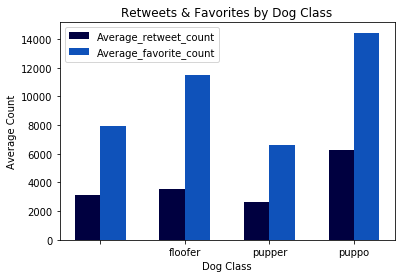

In [61]:
#group by class
avg_retweet_count_dog_stage = archive_c.groupby("Class").retweet_count.mean()
avg_favorite_count_dog_stage = archive_c.groupby("Class").favorite_count.mean()

width = 0.3 # width of the bar
ind = np.arange(len(avg_favorite_count_dog_stage)) # x-axis ticks
locations = ind + width / 2  # xtick locations
labels = avg_favorite_count_dog_stage.index  # xtick labels


retweet_count_bars = plt.bar(ind, avg_retweet_count_dog_stage, width, color='#000040', label= 'Average_retweet_count')
favorite_count_bars = plt.bar(ind +width , avg_favorite_count_dog_stage, width, color='#0F52BA', label= 'Average_favorite_count')
plt.xticks(locations, labels)
plt.title('Retweets & Favorites by Dog Class')
plt.ylabel('Average Count')
plt.xlabel('Dog Class')
plt.legend();

In [62]:
# Puppo  seeems to be the most loved class since it has the most average retweets and favoirte count
avg_retweet_count_dog_stage

Class
           3134.760207
floofer    3512.300000
pupper     2617.755760
puppo      6275.250000
Name: retweet_count, dtype: float64

In [63]:
#dog type dist
dogg_breed = pred_c.groupby(['dog_breed']).count()
dogg_breed = dogg_breed.sort_values(by=['img_num'], ascending=False)



In [64]:
dogg_breed.head()

,img_num,jpg_url,conf,is_dog
dog_breed,,,,
golden_retriever,290,290,290,290
Labrador_retriever,283,283,283,283
Chihuahua,185,185,185,185
Pembroke,143,143,143,143
Cardigan,115,115,115,115


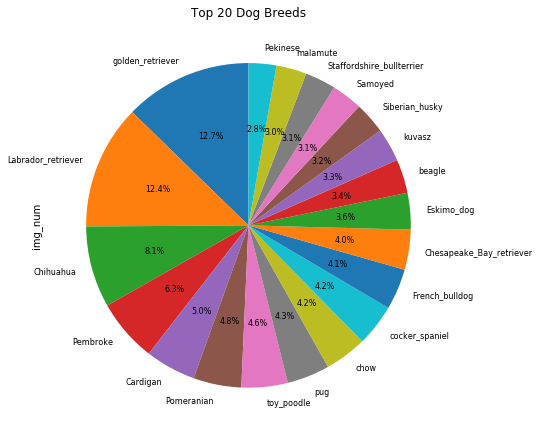

In [65]:
plt.figure(figsize=(16,8))
ax1 = plt.subplot(121, aspect='equal')
dogg_breed10= dogg_breed.head(20)
dogg_breed10.plot(kind='pie', y = 'img_num', ax=ax1, autopct='%1.1f%%', title = 'Top 20 Dog Breeds',
 startangle=90, shadow=False, legend = False, fontsize=8)


In [66]:
# the most common dog breed is golden_retriever (12.7%) followed by labrador_retriever (12.4%)

In [67]:
#grouping
grouped = archive_c.groupby('name').size().reset_index(name='counts')
grouped.head()

,name,counts
0,Abby,2
1,Ace,1
2,Acro,1
3,Adele,1
4,Aiden,1


In [68]:
#sorting
sgrouped = grouped.sort_values(by = 'counts', ascending=False,).reset_index(drop=True)
sgrouped

,name,counts
0,None,601
1,Lucy,11
2,Charlie,11
3,Cooper,10
4,Oliver,10
5,Penny,9
6,Tucker,9
7,Winston,8
8,Lola,8
9,Sadie,8


In [69]:
#most common dog names df without none
name = sgrouped[1:11]
name 

,name,counts
1,Lucy,11
2,Charlie,11
3,Cooper,10
4,Oliver,10
5,Penny,9
6,Tucker,9
7,Winston,8
8,Lola,8
9,Sadie,8
10,Toby,7


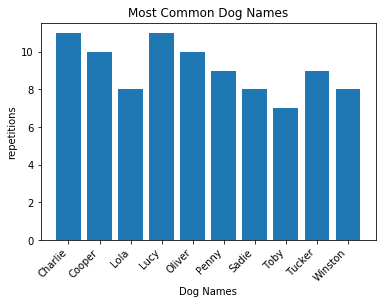

In [70]:
plt.xlabel('Dog Names')
plt.ylabel("repetitions")
plt.title('Most Common Dog Names')
x = name['name']
y = name['counts']
plt.xticks( rotation=45, horizontalalignment='right')

plt.bar(x,y) ;

In [109]:
archive_c.head()


,tweet_id_x,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,Image_url,rating_numerator,rating_denominator,name,retweet_count,favorite_count,Class
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,8853.0,39467.0,
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,6514.0,33819.0,
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,4328.0,25461.0,
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,8964.0,42908.0,
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,9774.0,41048.0,


In [155]:
archive_c['year'] = pd.DatetimeIndex(archive_c['timestamp']).year
archive_c['month'] = pd.DatetimeIndex(archive_c['timestamp']).month

In [156]:
archive_c.sample()

,tweet_id_x,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,Image_url,rating_numerator,rating_denominator,name,retweet_count,favorite_count,Class,year,month,mnth_yr,yr_mnth
1754,678798276842360832,NaN,NaN,2015-12-21 04:44:55,"<a href=""http://twitter.com/download/iphone"" r...",This is Linda. She fucking hates trees. 7/10 h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/678798276...,7.0,10,Linda,1553.0,3864.0,,2015,12,15-12,15-12


In [198]:
archive_c['yr_mnth'] = archive_c['timestamp'].apply(lambda x: x.strftime('%y-%m')) 
archive_c.head(2)


,tweet_id_x,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,Image_url,rating_numerator,rating_denominator,name,retweet_count,favorite_count,Class,year,month,mnth_yr,yr_mnth
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,8853.0,39467.0,,2017,8,17-08,17-08
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,6514.0,33819.0,,2017,8,17-08,17-08


In [187]:
archive_d = archive_c.groupby(['yr_mnth'])['retweet_count', 'favorite_count'].mean().reset_index()
archive_d.head(1)

,yr_mnth,retweet_count,favorite_count
0,15-11,570.593023,1296.317829


NameError: name 'yr_mnth' is not defined

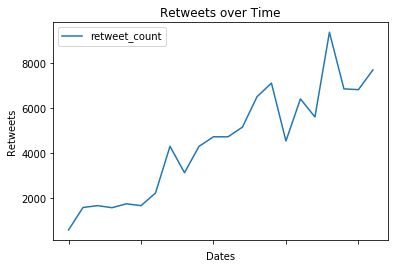

In [186]:
archive_d.plot( 'yr_mnth'  ,'retweet_count'  )
plt.xlabel('Dates')
plt.ylabel("Retweets")
plt.title('Retweets count over Time')
plt.xticks(np.arange(min('yr_mnth'), max(yr_mnth)+1, 1.0))
marker='o';


NameError: name 'yr_mnth' is not defined

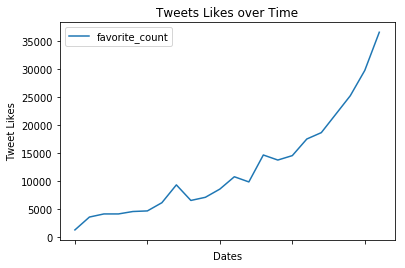

In [196]:
archive_d.plot( 'yr_mnth'  ,'favorite_count'  )
plt.xlabel('Dates')
plt.ylabel("Tweet Likes")
plt.title('Tweets Likes over Time')
plt.xticks(np.arange(min('yr_mnth'), max(yr_mnth)+1, 1.0))
marker='o';